### Notebook to plot Bichan initial conditions
The 1 km ROMS model output is used 

In [1]:
#Packages 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as tick
import numpy as np
import xarray as xr
import xroms
import cmocean.cm as cmo
import cmocean
import warnings
warnings.filterwarnings("ignore") #turns off annoying warnings

### Open model output 

In [2]:
path = '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/1km_qdrag/roms_his.nc'
ds = xroms.open_netcdf(path)
ds,grid = xroms.roms_dataset(ds)
ds

<xarray.Dataset> Size: 103GB
Dimensions:         (tracer: 2, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 302,
                     xi_rho: 102, xi_u: 101, eta_v: 301, ocean_time: 721)
Coordinates: (12/21)
  * s_rho           (s_rho) float64 240B -0.9833 -0.95 ... -0.05 -0.01667
  * s_w             (s_w) float64 248B -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    x_rho           (eta_rho, xi_rho) float64 246kB dask.array<chunksize=(302, 102), meta=np.ndarray>
    y_rho           (eta_rho, xi_rho) float64 246kB dask.array<chunksize=(302, 102), meta=np.ndarray>
    x_u             (eta_rho, xi_u) float64 244kB dask.array<chunksize=(302, 101), meta=np.ndarray>
    y_u             (eta_rho, xi_u) float64 244kB dask.array<chunksize=(302, 101), meta=np.ndarray>
    ...              ...
    z_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 5GB dask.array<chunksize=(1, 31, 301, 102), meta=np.ndarray>
    z_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 5GB dask.array<chunksize=(1, 31, 301, 101), meta=np.ndarray>
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 5GB dask.array<chunksize=(1, 30, 302, 102), meta=np.ndarray>
    z_rho_u         (ocean_time, s_rho, eta_rho, xi_u) float64 5GB dask.array<chunksize=(1, 30, 302, 101), meta=np.ndarray>
    z_rho_v         (ocean_time, s_rho, eta_v, xi_rho) float64 5GB dask.array<chunksize=(1, 30, 301, 102), meta=np.ndarray>
    z_rho_psi       (ocean_time, s_rho, eta_v, xi_u) float64 5GB dask.array<chunksize=(1, 30, 301, 101), meta=np.ndarray>
Dimensions without coordinates: tracer, Nuser
Data variables: (12/109)
    ntimes          int32 4B ...
    ndtfast         int32 4B ...
    dt              float64 8B ...
    dtfast          float64 8B ...
    dstart          object 8B ...
    nHIS            int32 4B ...
    ...              ...
    dz_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 5GB dask.array<chunksize=(1, 31, 302, 101), meta=np.ndarray>
    dz_v            (ocean_time, s_rho, eta_v, xi_rho) float64 5GB dask.array<chunksize=(1, 30, 301, 102), meta=np.ndarray>
    dz_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 5GB dask.array<chunksize=(1, 31, 301, 102), meta=np.ndarray>
    dz_psi          (ocean_time, s_rho, eta_v, xi_u) float64 5GB dask.array<chunksize=(1, 30, 301, 101), meta=np.ndarray>
    dz_w_psi        (ocean_time, s_w, eta_v, xi_u) float64 5GB dask.array<chunksize=(1, 31, 301, 101), meta=np.ndarray>
    dA              (eta_rho, xi_rho) float64 246kB dask.array<chunksize=(302, 102), meta=np.ndarray>
Attributes: (12/25)
    file:              roms_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Baroclinic instabilitiy in a shallow, periodic channel.
    var_info:          External/varinfo.dat
    ...                ...
    compiler_command:  /opt/cray/pe/mpich/8.1.28/ofi/gnu/12.3/bin/mpif90
    compiler_flags:    -frepack-arrays -fallow-argument-mismatch -O3 -ffast-m...
    tiling:            010x015
    history:           ROMS/TOMS, Version 3.9, Friday - November 8, 2024 -  6...
    ana_file:          ROMS/Functionals/ana_btflux.h, /pscratch/sd/k/kehinson...
    CPP_options:       BICHAN, ANA_BSFLUX, ANA_BTFLUX, ANA_GRID, ANA_INITIAL,...

### Code below from Schlichting et al. (2024) for salinity, temperature, and density.

In [6]:
#Salinity
salt = grid.interp(ds.salt,'X')
salt = salt.assign_coords({'z_rho_u':(ds.z_rho_u),'y_u':(ds.y_u),'xi_u':(ds.xi_u)})
salt = salt[0,-1].load() # First time, surface

#Interpolate vertical coordinate for plotting
zw_u = grid.interp(ds.z_w, 'X')
zw_u = zw_u.assign_coords({"x_u": ds.x_u})

#x/y coordinates
xu = (ds.x_u/1000).values
yu = (ds.y_u/1000).values

#Temperature
temp = grid.interp(ds.temp,'X')
temp = temp.assign_coords({'z_rho_u':(ds.z_rho_u),'y_u':(ds.y_u),'xi_u':(ds.xi_u)})
temp = temp[0,:,:,50].load()

#Density from linear EOS
rhol = 1027*((1+7.6*(10**-4*(ds.salt-35)))-1.7*10**-4*(ds.temp-25))
rhol = grid.interp(rhol,'X')
rhol = grid.interp(rhol,'Z', boundary = 'extend')
rhol = rhol.assign_coords({'z_w_u':(ds.z_w_u),'y_u':(ds.y_u)})
rho_cs = rhol[0,:,:,50].load()

#Velocities
u = ds.u[0,:,:,50].load()
v = ds.v[0,:,:,50].load()
#Print u velocity range for colorbar limits
print(u.max().values)
print(u.min().values)
#Check there is no N-S flow
print(v.max().values)
print(v.min().values)
#Density extrema
print(rhol[0,-1].min().values)
print(rhol[0,-1].max().values)

0.49323177337646484
0.0067682284861803055
0.0
0.0
1011.45074
1042.7847


### Plan view of salinity by itself, the font size needs to be changed to match the section view

Text(0.5, 1.0, '(a) Surface salinity')

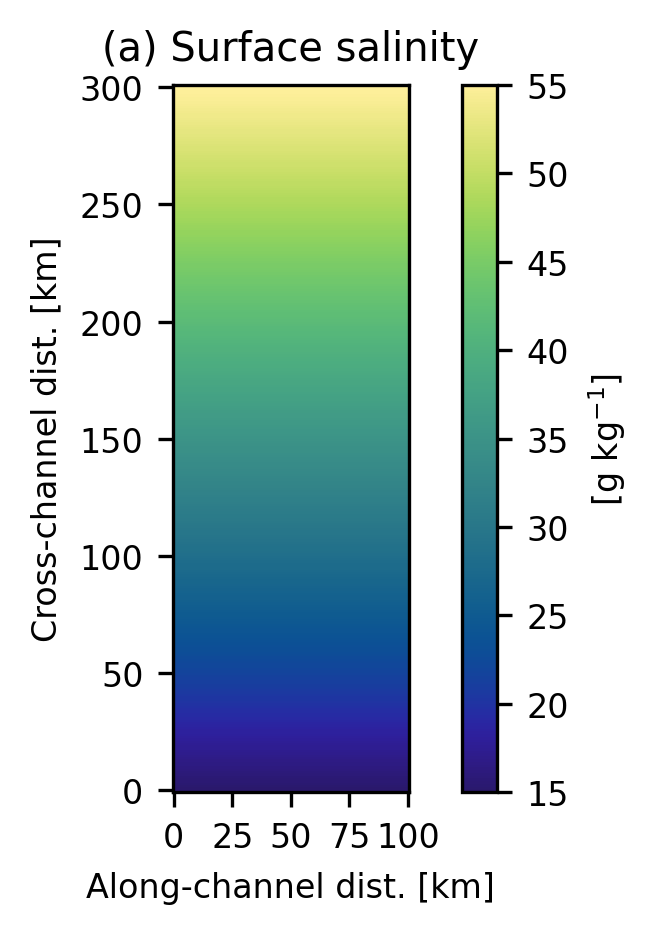

In [28]:
plt.rcParams.update({'font.size': 8})

fig,ax=plt.subplots(1,
                    figsize=(2.3,3),
                    dpi=300,
                    constrained_layout=True)

m = ax.pcolormesh(xu,
                  yu,
                  salt,
                  cmap=cmo.haline,
                  vmin=15,
                  vmax=55,)

# m1 = ax.contour(xrho,
#                yrho,
#                rhol[0,-1],
#                levels = np.arange(1010,1050,5),
#                colors = 'k')


fig.colorbar(m,ax=ax,label='[g kg$^{-1}$]')
ax.set_xlabel('Along-channel dist. [km]')
ax.set_ylabel('Cross-channel dist. [km]')
ax.set_aspect(1)
ax.set_xticklabels(['0', '25', '50', '75', '100'])
ax.set_xticks([0,25,50,75,100])
# ax.minorticks_on()
ax.set_title('(a) Surface salinity')

### Section view of $\theta$ and $u$ with density contours overlaid

Text(0.5, 0, 'Cross-channel distance [km]')

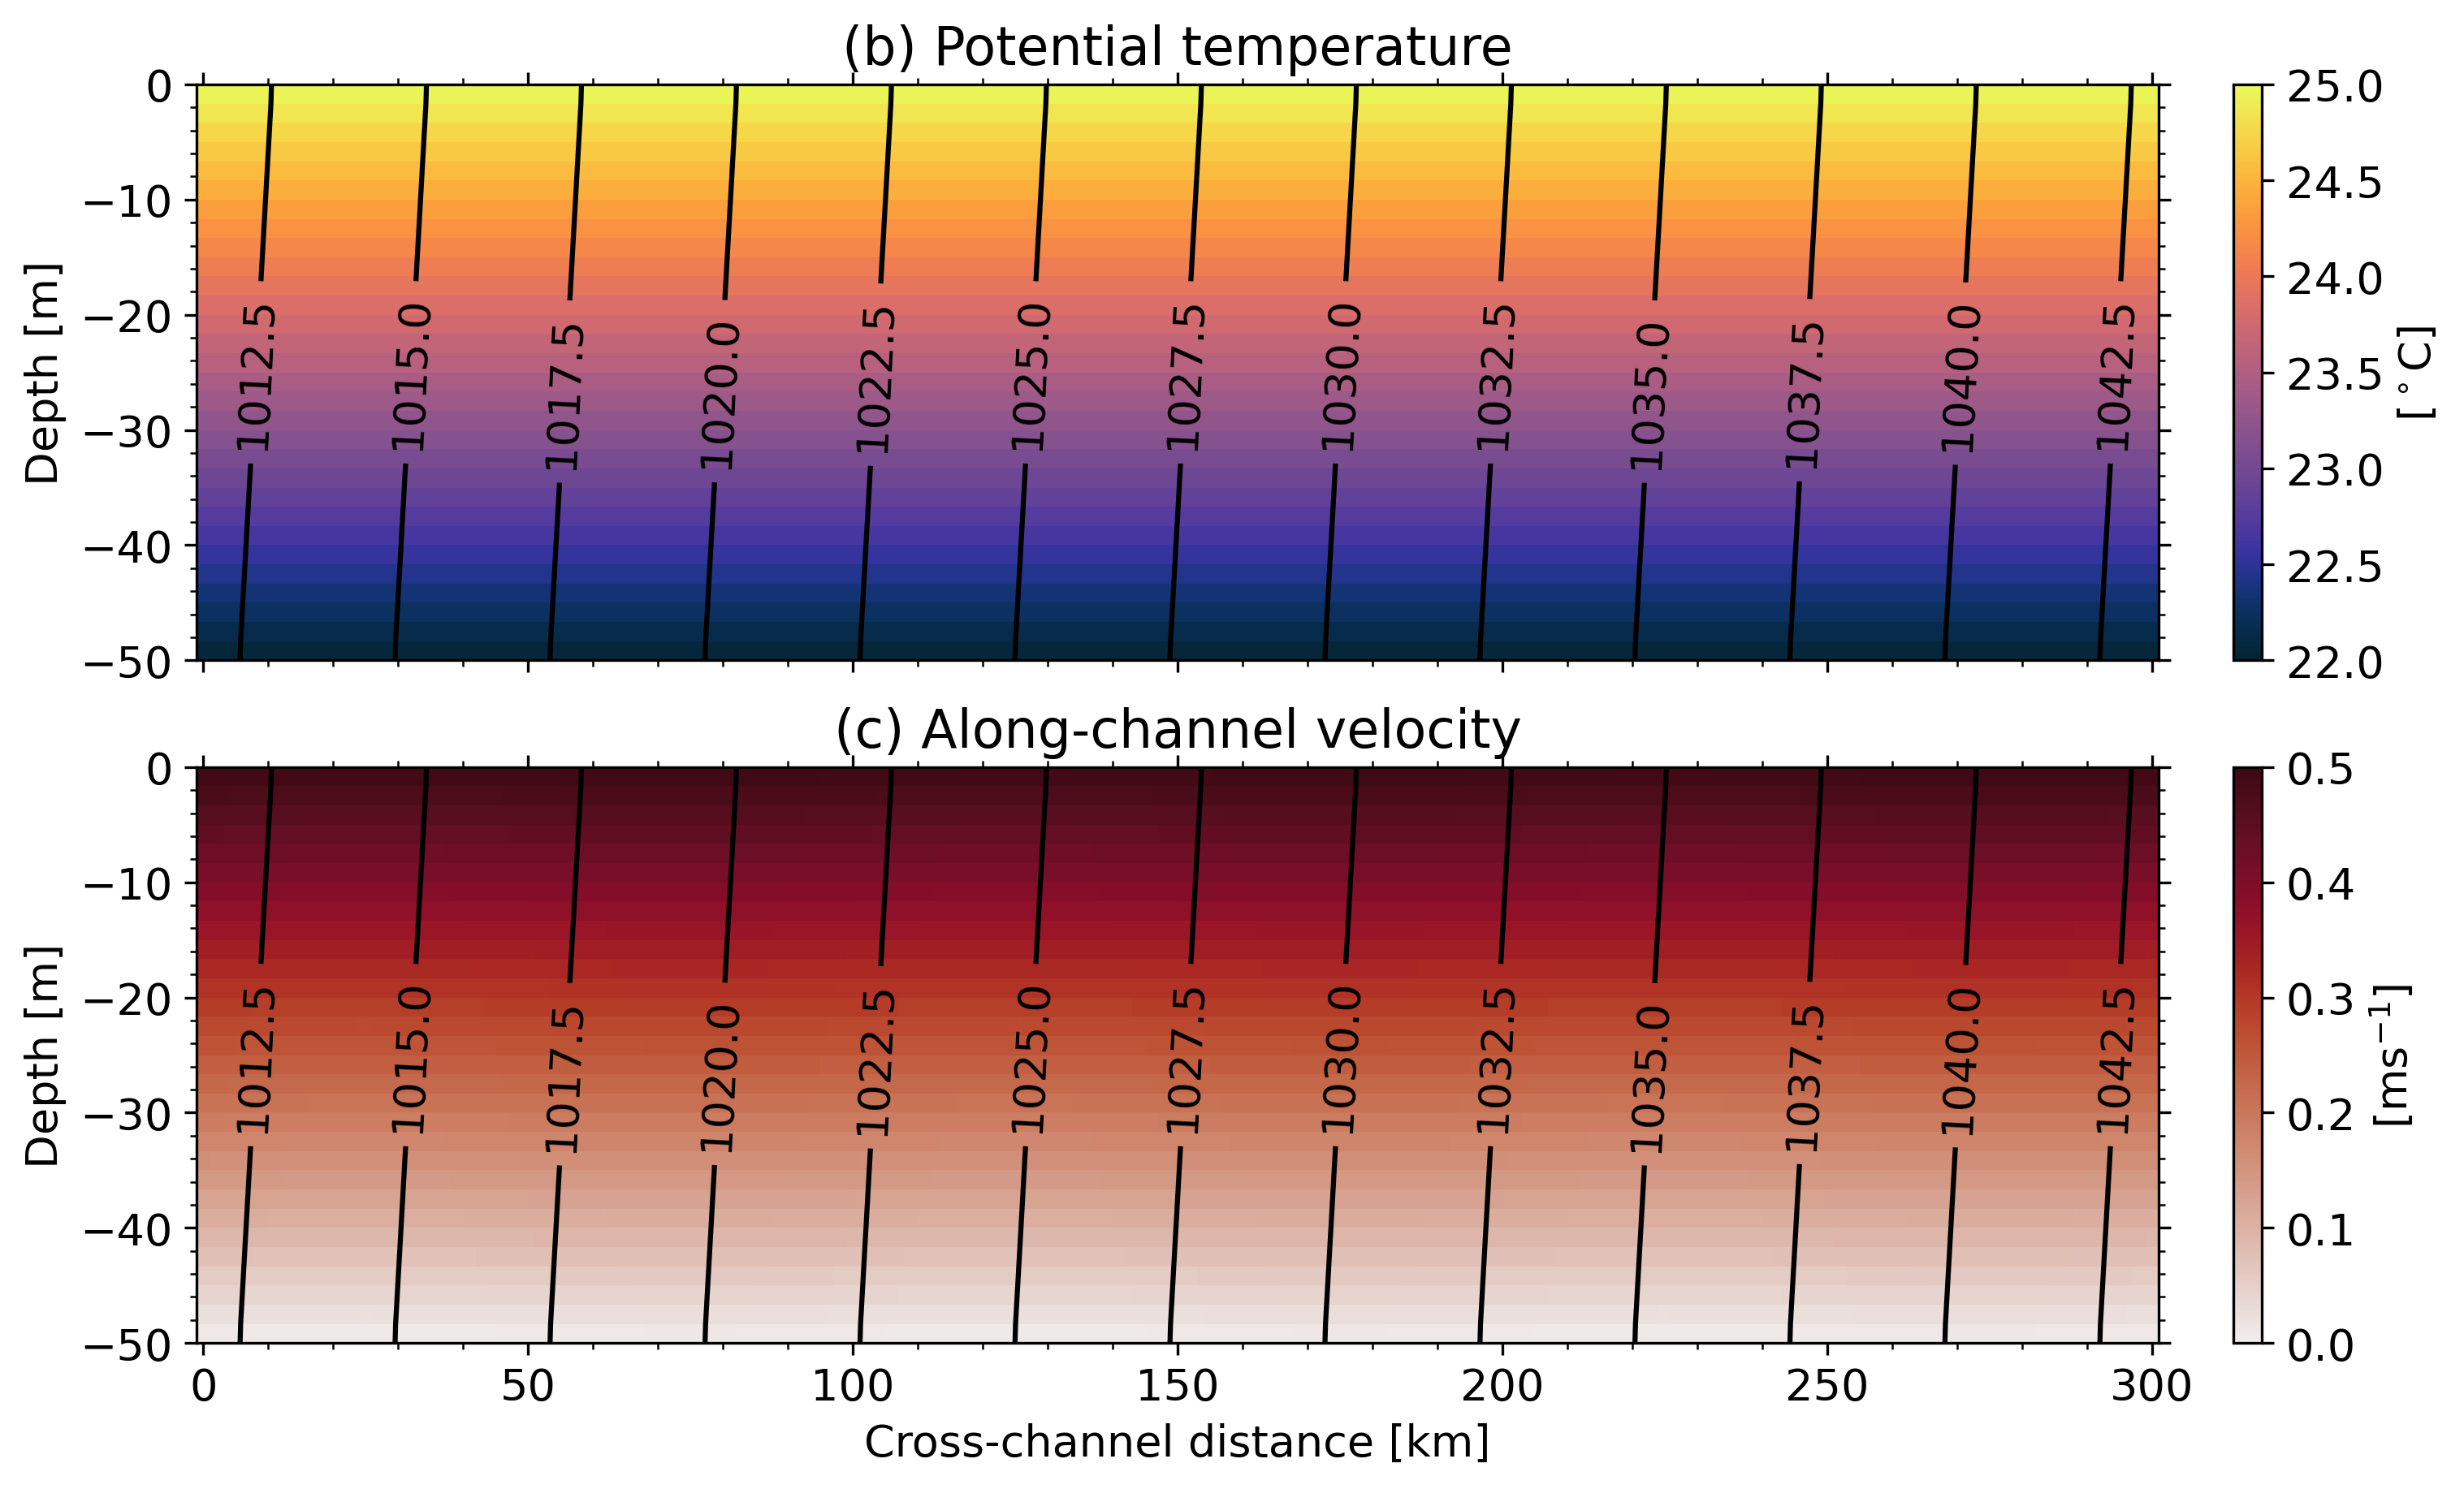

In [27]:
plt.rcParams.update({'font.size': 13})
nrows=2;ncols=1
fig,ax=plt.subplots(nrows,ncols,
                    figsize=(10,6),
                    dpi=300,
                    constrained_layout=True)

m = temp.plot(ax=ax[0],
              x='y_u',
              y='z_rho_u',
              cmap=cmo.thermal,
              vmin=22,vmax=25,
              add_colorbar=False,)
mc = rho_cs.plot.contour(ax = ax[0],
            x='y_u',
            y='z_w_u',
            levels = np.arange(1010,1050,2.5),
            colors = 'k')
fig.colorbar(m,ax=ax[0],label=r'[$^\circ$C]',pad=0.02)

m1 = u.plot(ax=ax[1],
           x='y_u',
           y='z_rho_u',
           cmap=cmo.amp,
           vmin=0,vmax=0.5,
           add_colorbar=False,)

m1c = rho_cs.plot.contour(ax = ax[1],
            x='y_u',
            y='z_w_u',
            levels = np.arange(1010,1050,2.5),
            colors = 'k')

fig.colorbar(m1,ax=ax[1],label=r'[ms$^{-1}$]',pad=0.02)
ax[0].clabel(mc, mc.levels)
ax[1].clabel(m1c, m1c.levels)

ax[0].set_title('(b) Potential temperature')
ax[1].set_title('(c) Along-channel velocity')

for i in range(2):
    ax[i].set_xticklabels(['0', '50', '100', '150', '200','250','300'])
    ax[i].set_xticks([0,50e3,100e3,150e3,200e3,250e3,300e3])
    ax[i].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[i].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[i].minorticks_on()
    ax[i].set_ylabel('Depth [m]')

ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[1].set_xlabel('Cross-channel distance [km]')

### Check the vertical resolution 

In [117]:
print(ds.dz[0].where(ds.z_rho[0]>-1).mean().values)
print(ds.dz[0,:,1:100,1:-1].where(ds.z_rho[0,:,1:100,1:-1]>-1).mean().values)
print(ds.dz[0].mean().values)
print(ds.dz[0,:,1:100,1:-1].mean().values)

1.666666666666658
1.6666666666666583
1.6666666666666652
1.6666666666666667
